# EM Algorithm for Image Segmentation

## Begin by importing necessary libraries
Numpy for arrays, nibabel for loading analyze images, matplotlib for ploting.

In [1]:
# import libraries
import numpy as np
import nibabel as nb
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# load an example image
fname = 'AD01.img'
img = nb.load(fname)
I = img.get_fdata().squeeze()
dx = np.array(img.header.get_zooms())
nx = I.shape
x = [np.arange(n)*d for n,d in zip(nx,dx)]

In [3]:
# get a slice
J = I[:,:,I.shape[2]//2]
J = I[:,I.shape[1]//2,:].squeeze()

In [4]:
# show the slice
f,ax = plt.subplots()
extent=(x[0][0],x[0][-1],x[2][0],x[2][-1])
ax.imshow(J,cmap='gray',extent=extent,aspect='equal')
ax.set_title('Example T1 MRI slice')

<IPython.core.display.Javascript object>

Text(0.5,1,'Example T1 MRI slice')

## Set up EM algorithm

In [5]:
# start by plotting a histogram
f,ax = plt.subplots()
nbins = 100
bins = np.linspace(np.min(J),np.max(J),nbins)
ax.hist(J.ravel(),bins=bins)
ax.set_title('histogram of slice')


<IPython.core.display.Javascript object>

Text(0.5,1,'histogram of slice')

In [6]:
# choose number of classes, e.g. 3 for grey white and CSF
N = 4
# an initial guess for the mean of each class
mu = np.linspace(J.min(),J.max(),N)
print(mu)
# an initial guess for the variance of each class
var = np.var(J)*np.ones(N)/2.0
print(var)
pi = np.ones(N)/N

# plot these above
for m,v,p in zip(mu,var,pi):
    prob = np.exp(-(bins-m)**2/2.0/v)/np.sqrt(2.0*np.pi*v)
    ax.plot(bins,prob*(bins[1]-bins[0])*J.size*p)

[   0.          505.33333333 1010.66666667 1516.        ]
[51386.31119771 51386.31119771 51386.31119771 51386.31119771]


## Perform the E step
In the E step we compute the posterior probabilities of each class at each voxel, given our current estimates of the mean

In [7]:
def compute_prob(J,mu,var):
    prob = np.exp(-(J[:,:,None] - mu[None,None,:])**2/var[None,None,:]/2.0)/np.sqrt(2.0*np.pi*var[None,None,:])
    post = prob/np.sum(prob,2,keepdims=True)    
    return post
post = compute_prob(J,mu,var)
f,ax = plt.subplots(1,N)
for i in range(N):
    h = ax[i].imshow(post[:,:,i],clim=[0,1],extent=extent)
    plt.colorbar(mappable=h,ax=ax[i])
    ax[i].set_title('P[{}]'.format(i))
f.suptitle('Initial probabilities')

<IPython.core.display.Javascript object>

Text(0.5,0.98,'Initial probabilities')

## M step 
We estimate mean and variance parameters weighted by the above posteriors

In [8]:
def compute_params(J,post):
    pi = np.sum(post,axis=(0,1))/J.size
    mu = np.mean(J[:,:,None]*post, axis=(0,1))/pi
    J0 = J[:,:,None] - mu[None,None,:]
    var = np.mean(J0**2*post, axis=(0,1))/pi
    return mu,var,pi
mu,var,pi = compute_params(J,post)
# plot the results again
f,ax = plt.subplots()
nbins = 100
bins = np.linspace(np.min(J),np.max(J),nbins)
ax.hist(J.ravel(),bins=bins)
ax.set_title('histogram of slice after 1 iteration')

# plot these above
for m,v,p in zip(mu,var,pi):
    probplot = np.exp(-(bins-m)**2/2.0/v)/np.sqrt(2.0*np.pi*v)
    ax.plot(bins,probplot*(bins[1]-bins[0])*J.size*p)

<IPython.core.display.Javascript object>

## Repeat E-M iterations


<IPython.core.display.Javascript object>


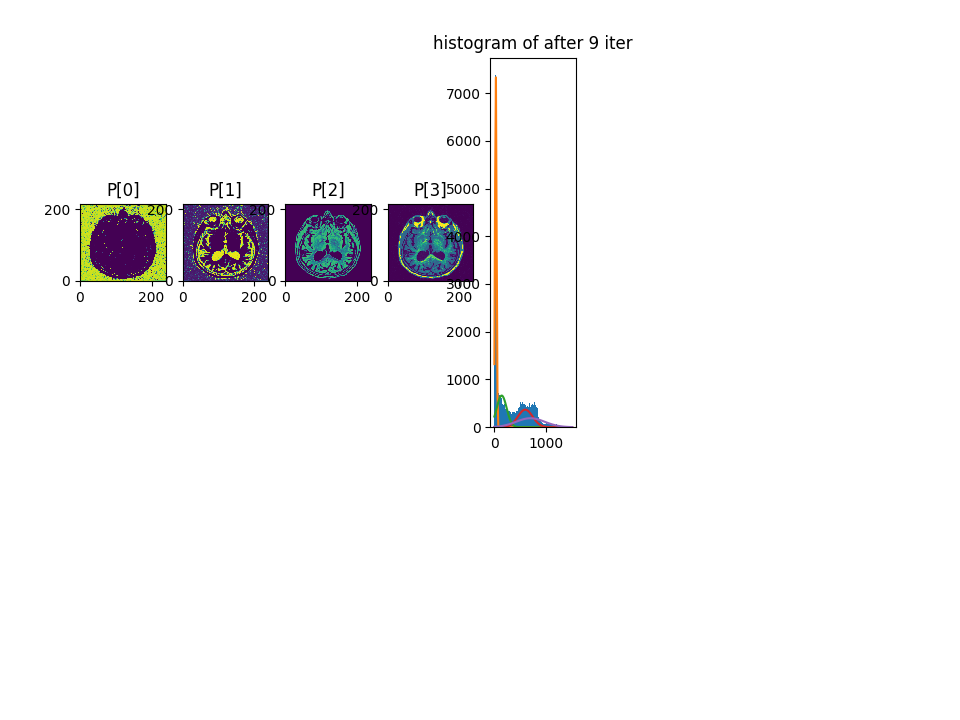

In [9]:
niter = 20
f,ax = plt.subplots(1,N+1)
for it in range(niter):
    post = compute_prob(J,mu,var)
    mu,var,pi = compute_params(J,post)
    
    # draw it    
    
    for i in range(N):
        ax[i].cla()
        h = ax[i].imshow(post[:,:,i],clim=[0,1],extent=extent)        
        ax[i].set_title('P[{}]'.format(i))
    ax[-1].cla()
    ax[-1].hist(J.ravel(),bins=bins)
    ax[-1].set_title('histogram of after {} iter'.format(it))
    for m,v,p in zip(mu,var,pi):
        probplot = np.exp(-(bins-m)**2/2.0/v)/np.sqrt(2.0*np.pi*v)
        ax[-1].plot(bins,probplot*(bins[1]-bins[0])*J.size*p)
    
    f.canvas.draw()

## Find labels
Find the maximum likelihood labels

In [10]:
post.shape

(256, 180, 4)

<IPython.core.display.Javascript object>


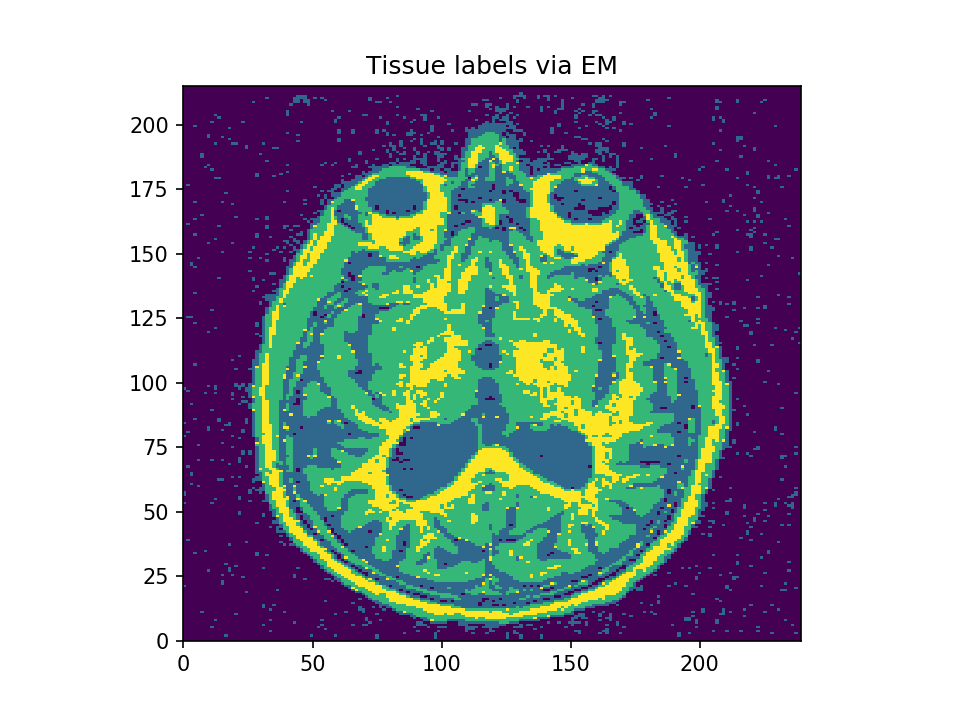

Text(0.5,1,'Tissue labels via EM')

In [13]:
L = np.zeros_like(J)
for i in range(N):
    L += i * (post[:,:,i] == np.max(post,axis=2))
f,ax = plt.subplots()
ax.imshow(L,extent=extent)
ax.set_title('Tissue labels via EM')